In [6]:
from datetime import datetime, timezone, timedelta
from collections import defaultdict
from time import time
import json
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tweepy

In [7]:
#inputs
bearer_token = "AAAAAAAAAAAAAAAAAAAAAH4BlAEAAAAA3Dd4SGtdK%2FWbAqlEdIcXzoPB4%2BA%3DwDjEbymhTQgnmvHM8Vvetae79bgdBz1eyHWSyXZVqRnCCir1nA" #mpolo
limit = 2 #number of requests of `max_results` tweets each

TODO: `search_recent_tweets` is up to 7 days. To search further back, use [search_all_tweets](https://docs.tweepy.org/en/stable/client.html#tweepy.Client.search_all_tweets) instead (and add `start_time` parameter). But it needs the [academic research access](https://developer.twitter.com/en/docs/projects). It also increases the monthly cap from 500,000 to 10 million, `max_results` from 100 to 500, and allows to use `-is:nullcast ` to filter out some ads.

In [8]:
#create paginator
client = tweepy.Client(bearer_token)
paginator = tweepy.Paginator(
    method = client.search_recent_tweets,
    limit = limit,
    query = (
        '(context:131.825047692124442624 OR context:152.825047692124442624) ' #https://github.com/twitterdev/twitter-context-annotations
        '-is:retweet ' #only original tweets
        '-is:reply '
        '-is:quote '
        '-has:links ' #no tweets with embedded images etc.
        '-has:media '
        'lang:en'),
    end_time = (datetime.now(timezone.utc)-timedelta(days=6)).isoformat(), #go backwards from 6 days ago
    expansions = ['author_id'], #TODO search doc for other usefull expansions
    max_results = 100,
    tweet_fields = ['public_metrics'], #TODO search doc for other usefull tweet fields
    user_fields = ['public_metrics']) #TODO search doc for other usefull user fields

#download tweets
data = defaultdict(list)
for response in paginator:
    for tweet, user in zip(response.data, response.includes['users']):
        if tweet.author_id == user.id: #some don't match for no reason
            data['text'] += [tweet.text]
            data['likes'] += [tweet.public_metrics['like_count']]
            data['followers'] += [user.public_metrics['followers_count']]

#save tweets
dir_ = f'debug_sets/{int(time() % 1e6)}/' #unique for 11 days
os.makedirs(dir_)
pd.DataFrame(data).to_csv(dir_+'dataset.csv', index=False)
with open(dir_+'metadata.json', mode='w') as fp:
    json.dump(paginator.kwargs, fp)
dir_

'debug_sets/619688/'

In [57]:
#load tweets
df = pd.read_csv(dir_+'dataset.csv')
df['likes'] += 1 #start likes from 1 for simplicity
df['followers'] += 1 #start followers from 1 for simplicity
df.tail(2)

,text,likes,followers
9074,Issit weird that I prefer having hot drinks in...,11,5566
9075,"this is a lunch's menu, Stewed Chicken🍗, sever...",1,32


(0.00038013004165193397, 0.21627973459819225)

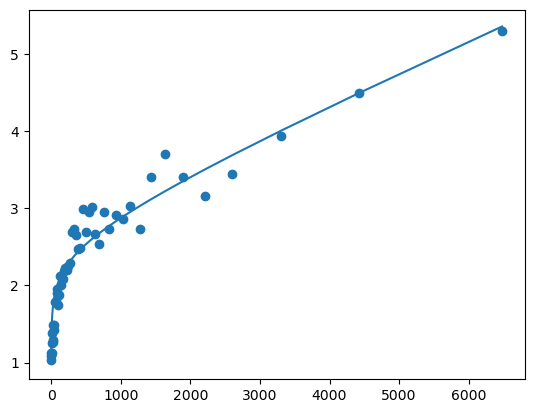

In [67]:
#remove outliers TODO tune q (eg.: 0.95)
q = df.quantile(0.95, numeric_only=True) #numeric_only to fix warning
df_q = df[(df['likes'] < q['likes']) & (df['followers'] < q['followers'])].copy() #copy to fix warning

#group by followers TODO tune number of groups (eg.: 50)
df_q.sort_values(by='followers', inplace=True, ignore_index=True)
df_q['group'] = df_q.index//(len(df_q)/50) #groups of same size
df_q = df_q.groupby('group').mean(numeric_only=True) #numeric_only to fix warning

#plot average followers vs average likes
x = df_q['followers']
y = df_q['likes']
plt.scatter(x, y)

#fit curve and plot it
def curve(x, a, b):
    return 1 + a*x + b*np.log(x) #both followers and likes start from 1
(a, b), _ = curve_fit(curve, xdata=x, ydata=y)
plt.plot(x, curve(x, a, b))
a, b

In [82]:
#get popularity by normalizing likes
df['popularity'] = df['likes']/curve(df['followers'], a, b)

#assign popularity level
df['pop_level'] = df['popularity'].apply(lambda x: 0 if x<0.5 else 1 if x<2 else 2)
df.sample(2)

,text,likes,followers,popularity,pop_level
5111,"Note to self: don’t eat two steaks, AND a frie...",8,320,3.376649,2
7735,Leftover brown stew chicken 🥰🥰🥰🥰🥰 The place we...,2,1566,0.627688,1


TODO imo vedi grafico sopra (quello dove fitti il log) e vedi a quanti follower ci si aspetta almeno un like (2 visto che uno lo hai regalato). Elimina tutti i tweet con zero like  (1 visto che...) e meno follower perché non danno informazioni.
Cioè se ha pochissimi follower e cmq 2 like allora sai che buono, ma se ha 1 like e boh tipo 20 follower non puoi dire che il tweet fa schifo visto che non ci si aspetta più like comunque. Cioè son praticamente delle osservazioni senza label e quindi vanno tolte. Pensa anche a 1 like e 1 follower (entrambi regalati), viene popularity 1 cioé nella media ma in verità non si può giudicare. O forse boh van bene lo stesso perché spostano gli altri (cioé fanno scalare di classe quelli con stesso numero di like e più follower, che ci sta). pensaci. intanto lasciali per semplicità

In [ ]:
"""
set_id = 000000
df[['text', 'pop_level']].to_csv(f'debug_set_{set_id}.csv', index=False)
df = pd.read_csv(f'debug_set_{set_id}.csv')
df
#"""